# From  [SABR Goes Normal](http://janroman.dhis.org/finance/OIS/Artiklar%20%C3%B6vrigt/SABR%20goes%20Normal.pdf)


Consider $dS_t =\sigma_tdW_t$, $d\sigma_t = \gamma\sigma_tdB_t$, $d\langle W,B\rangle_t=\rho t$.

The Hagan implied vol expansion for this diffusion matches the expansion for a regular SABR with exponent $\beta$ (at the first order) assuming the initial volatility is rescaled by a factor $\frac{(1-\beta)(K-S_0)}{K^{1-\beta}-S_0^{1-\beta}}$. Let's denote by $b_0$ this adjusted initial volatility.

<br/>

The price of a call on $S$ with strike $K$ is then :
$E[(S_T-K)_+] = (S_0-K)_++\frac{1}{2}b_0^2\int_0^T E^{\alpha}[\delta(X_t)]dt$, where $X_t = \frac{S_t-K}{\alpha_t}$, $\alpha_t=\frac{\sigma_t}{b_0}$. Note that $\alpha$ defines a martingale.

<br/>

One thus needs to find a semi-closed form for the density of $X_t$ around 0.
First, under the martingale measure associated to $\alpha$, Ito formula yields the following diffusion for $X$ :

$dX_t = b_0\sqrt{q(X_t)}dW^{\alpha}_t$, $q(x)=1-2\rho\tilde{\gamma}x+\tilde{\gamma}^2x^2$, $\tilde{\gamma}=\frac{\gamma}{b_0}$.

<br/>

Consider $Y_t = J(X_t)$ where $J(x)=\int_{X_0}^x\frac{du}{b_0q(u)}$. Note that a closed-form exists for this integral and that it defines an monotonic, one-to-one change of variable:

$\int\frac{du}{b_0q(u)}=\frac{1}{b_0\tilde{\gamma}}\log\big(\sqrt{q(x)}-\rho+\tilde{\gamma}x\big)$

<br/>

We then have:

$dY_t = dW^{\alpha}_t + O(dt)$.

Neglecting the drift would give $X_t=J^{-1}(Y_t)$, the probability density of which is easy to derive from the normal distribution. To account for the missing drift, we approximate $X_t$ with $J^{-1}(Y_t)+L_t$ where $L_t$ is a deterministic function of $t$ calibrated so that the expectation of $X_t$ remains equal to $X_0-K$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from volmodels import *
plt.style.use('dark_background')

In [2]:
T = 1
LEGEND_SIZE = 32
FONT_SIZE = 32
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 100

## Numerical experiments

In [3]:
f = 2*ONE_PCT
beta = 0.2
vov = 40*ONE_PCT
rho = -40*ONE_PCT
moneyness_lo = 1/10
moneyness_hi = 2
sigma_0 = 27*ONE_BP

n_integral = 50

In [4]:
Model_Goes_Normal_N = SABR_Goes_Normal_N(beta=beta, vov=vov, rho=rho, f=f,\
                                         marking_mode='sigma_0', sigma_0=sigma_0,\
                                         n_strikes=N_STRIKES,\
                                         moneyness_lo=moneyness_lo, moneyness_hi=moneyness_hi,\
                                         n_integral=n_integral)

Model_N = SABR_Hagan_N(beta=beta, vov=vov, rho=rho, f=f,\
                       marking_mode='sigma_0', sigma_0=sigma_0,\
                       n_strikes=N_STRIKES,\
                       moneyness_lo=moneyness_lo, moneyness_hi=moneyness_hi,)

### Local time density

We study the local times of $X_t = \frac{S_t-K}{\alpha_t}$.
Local times correspond to the time option value of call/put, thanks to the Tanaka-Meyer formula :

$E[(S_T-K)_+] = (S_0-K)_++\frac{1}{2}b_0^2\int_0^T E^{\alpha}[\delta(X_t)]dt
$

where $(S_0-K)_+$ is the intrinsinc value of the call.

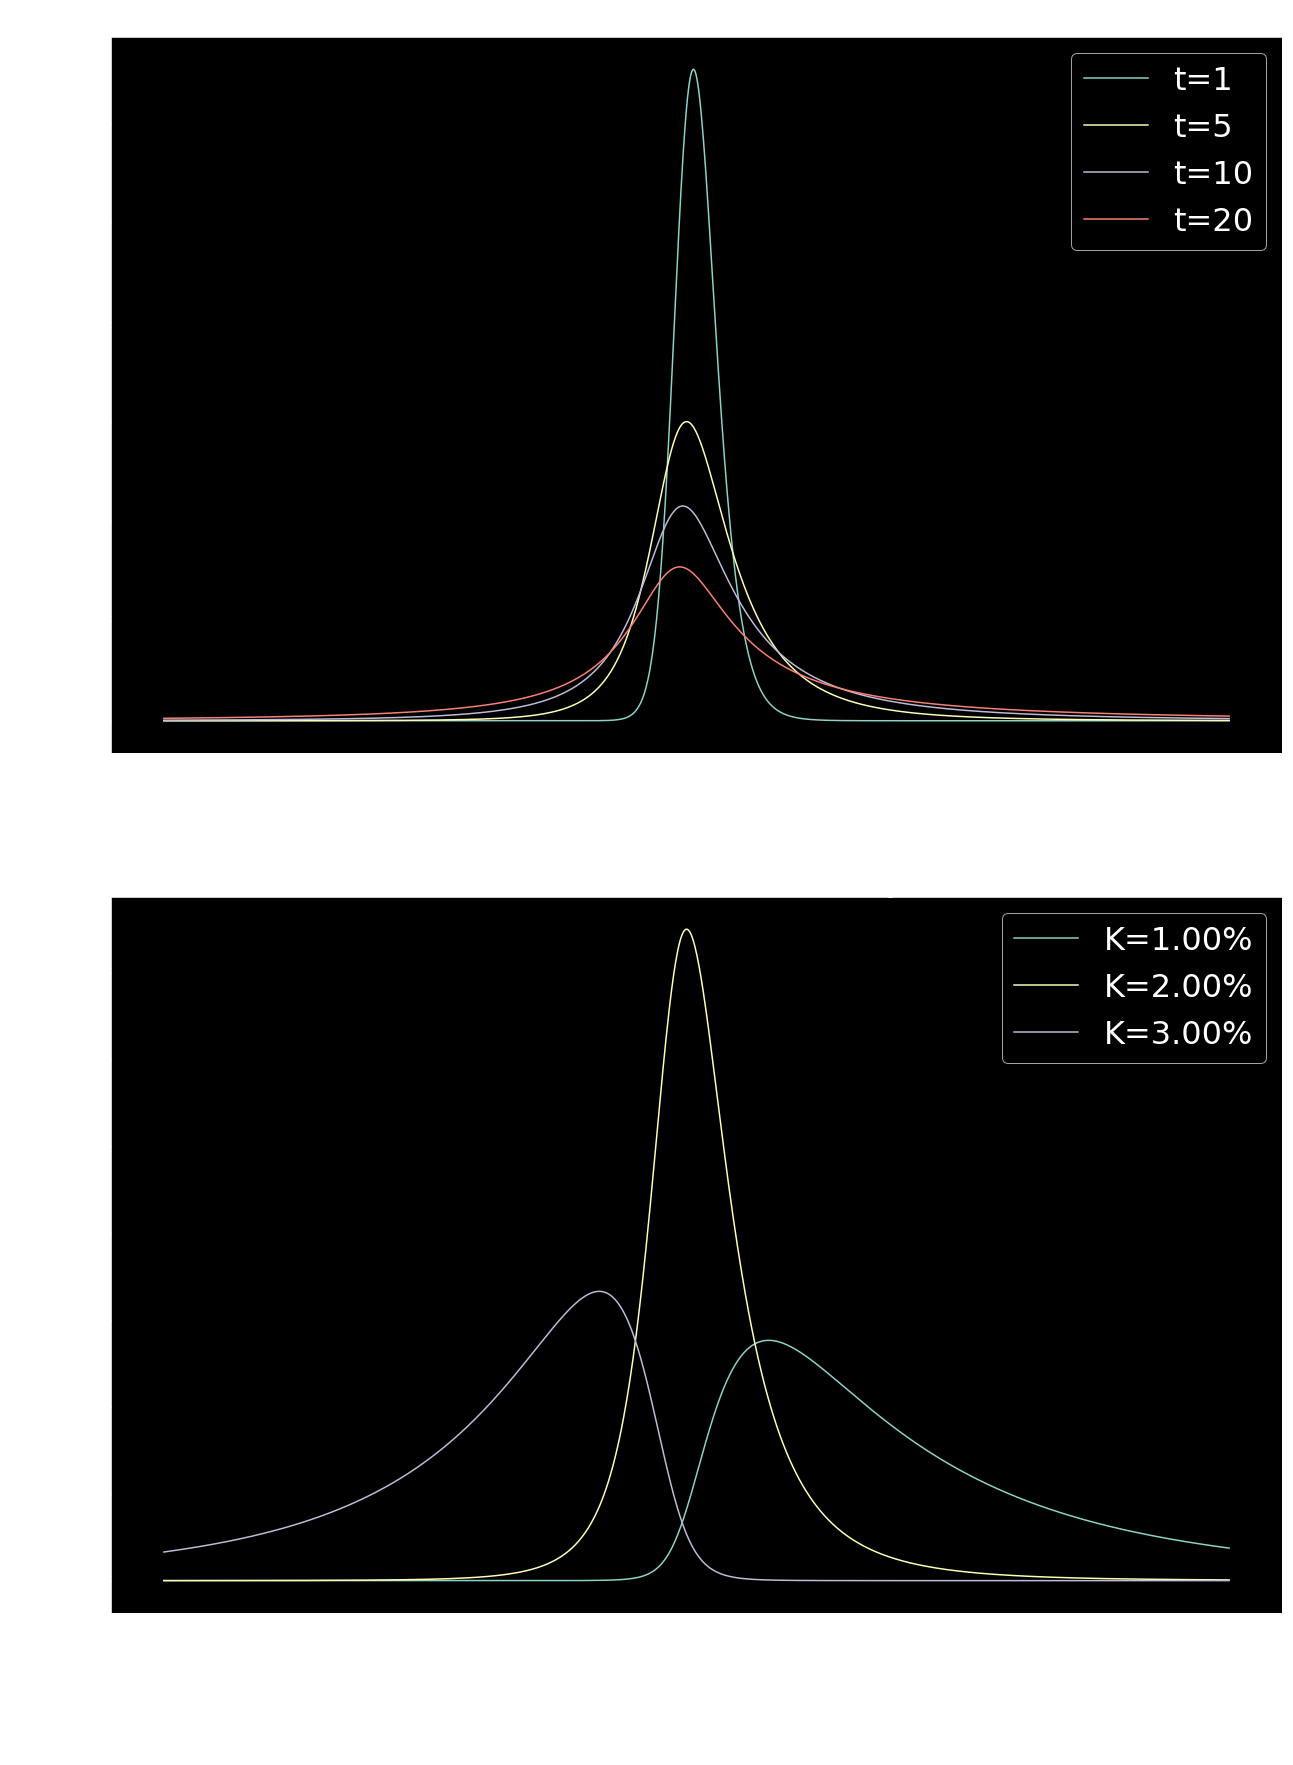

In [ ]:
xlabel = 'moneyness\n\n'
ylabel = 'local time'

xs = np.linspace(-3*ONE_PCT, 3*ONE_PCT, 1000)

ts = [1, 5, 10, 20]
K_shocks = [-1*ONE_PCT, 0, 1*ONE_PCT]

fig, axes = plt.subplots(figsize=(21, 29), nrows=2, ncols=1)

ax = axes[0]
for t in ts:
    density = partial(Model_Goes_Normal_N.local_time, t, K=f)

    ax.plot(xs, density(xs), label='t={}'.format(t))
    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.set_title('Local times ATM', fontsize=FONT_SIZE)
    ax.tick_params(labelsize=FONT_SIZE)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))

t = 5

ax = axes[1]
for K_shock in K_shocks:
    density = partial(Model_Goes_Normal_N.local_time, t, K=f+K_shock)

    ax.plot(xs, density(xs), label='K={:.2%}'.format(f+K_shock))
    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.set_title(r'Local times of $X_t-K$ at {}y'.format(t), fontsize=FONT_SIZE)
    ax.tick_params(labelsize=FONT_SIZE)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))


## Implied vol

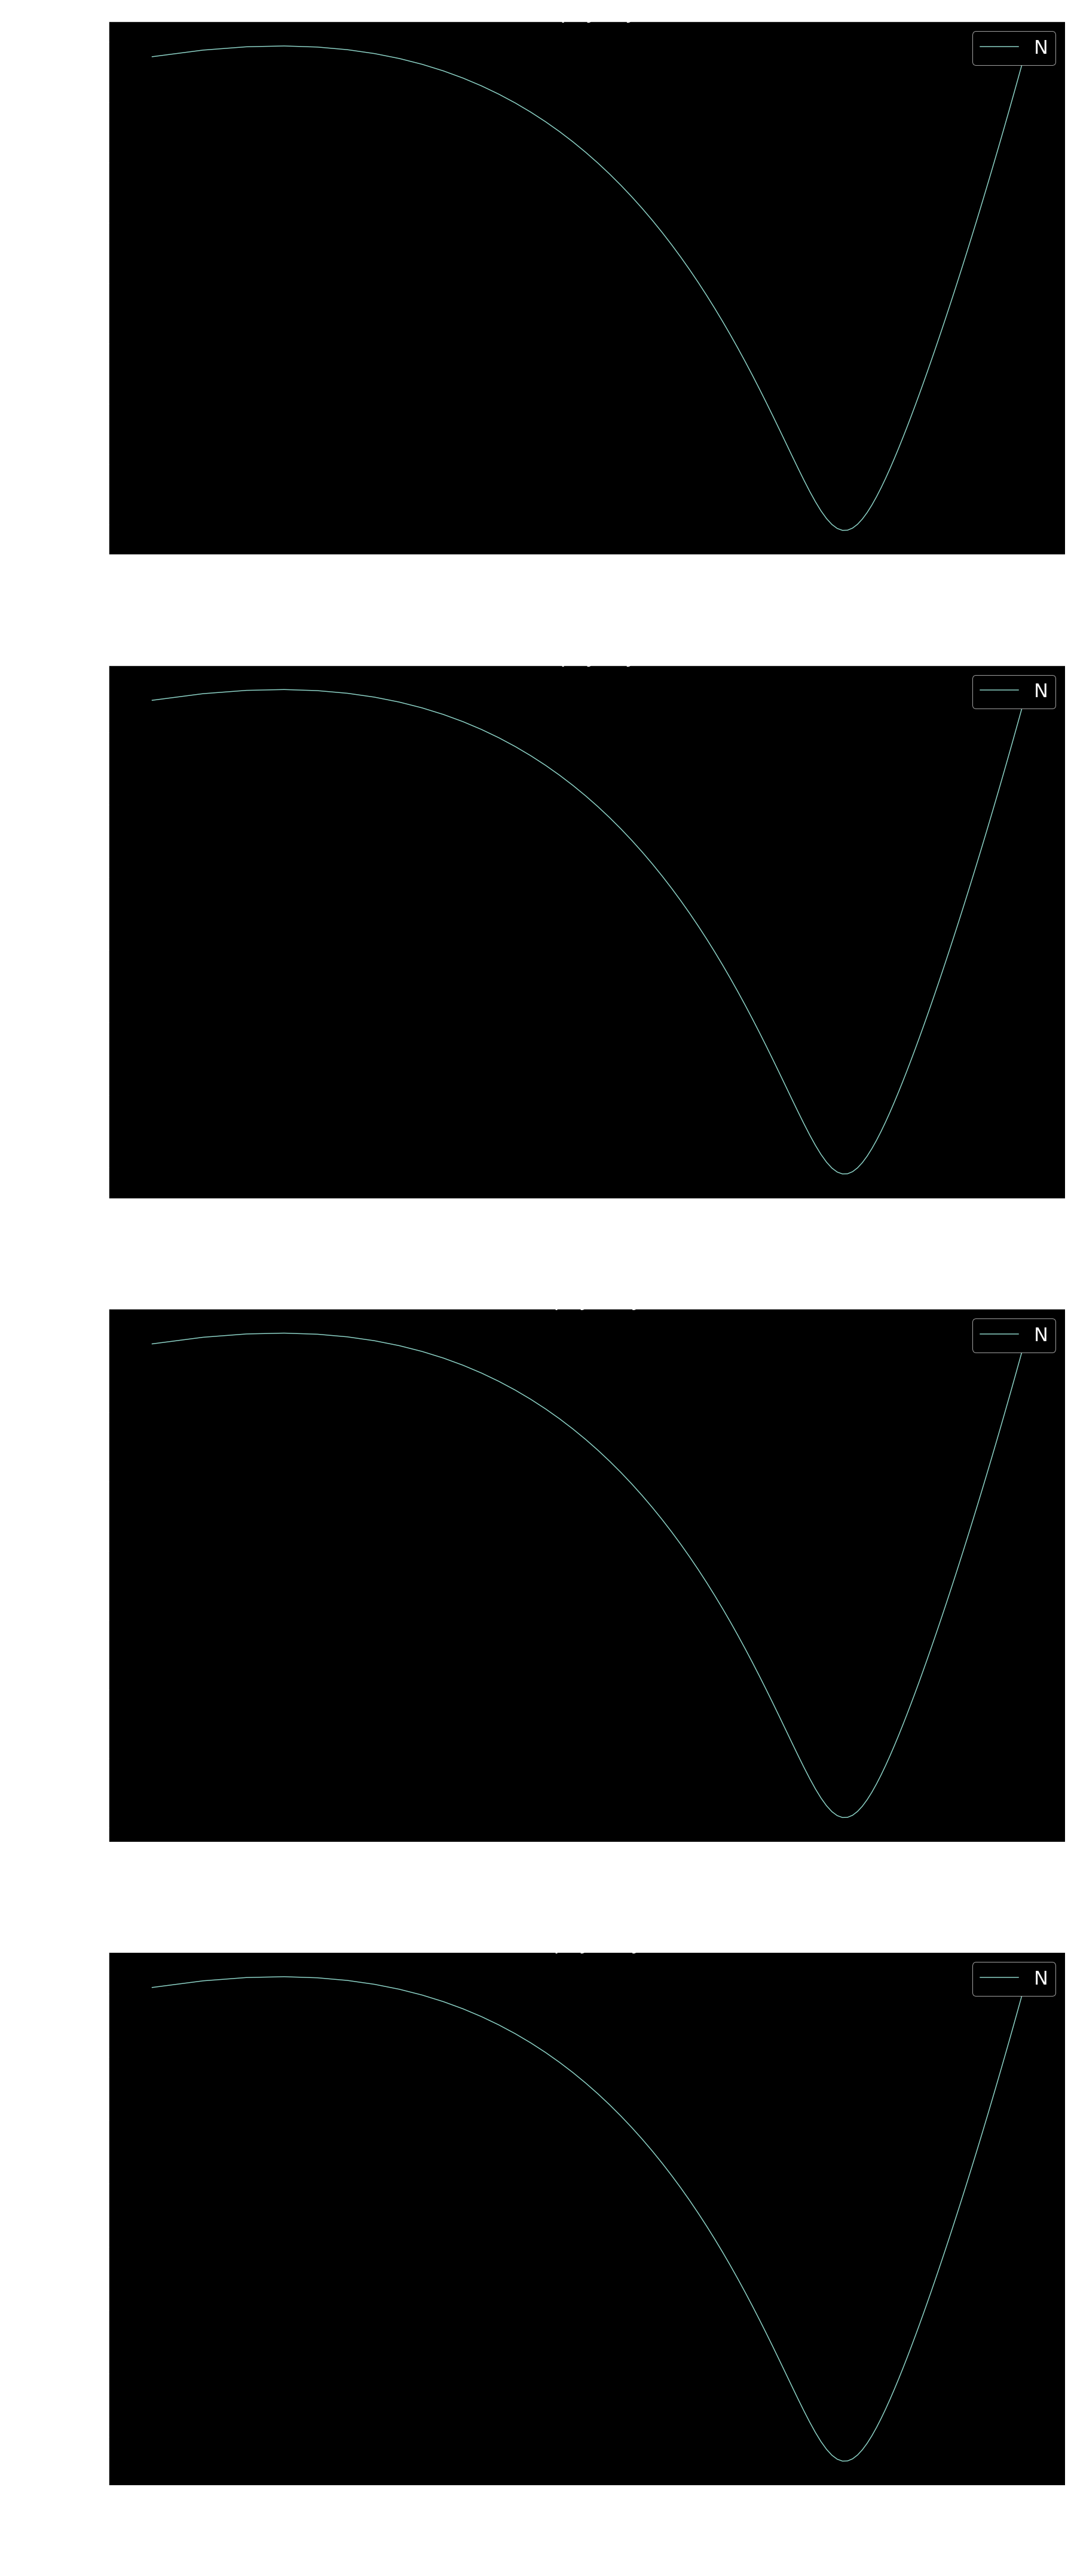

In [ ]:
xlabel = 'logmoneyness\n\n'
ylabel = 'implied vol'

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(figsize=(25, 60), nrows=4, ncols=1)

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_Goes_Normal_N.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    x_grid = Model_Goes_Normal_N.logmoneyness_grid

    smile = Model_Goes_Normal_N.smile.values()
    ax.plot(x_grid, smile, label='N')

    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.tick_params(labelsize=FONT_SIZE)
    ax.set_title('expiry={}y'.format(T_expiry), fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

## Implied density

Using the "SABR goes normal" pricing formula, the implied distribution that matches the one derived from Hagan vol expansion around ATM while avoiding negative density on the left wing

In [ ]:
xlabel = 'logmoneyness\n\n'
ylabel = 'pdf'

T_expiries = [1, 5, 10, 20]

fig, axes = plt.subplots(figsize=(25, 60), nrows=4, ncols=1)

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_Goes_Normal_N.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    
    x_grid = Model_Goes_Normal_N.logmoneyness_grid
    
    pdf_Goes_Normal_N = Model_Goes_Normal_N.pdf_curve.values()    
    pdf_N = Model_N.pdf_curve.values()

    ax.plot(x_grid, pdf_Goes_Normal_N, label='N "Goes Normal"')
    ax.plot(x_grid, pdf_N, label='N')
    
    ax.set_xlabel(xlabel, fontsize=FONT_SIZE)
    ax.set_ylabel(ylabel, fontsize=FONT_SIZE)
    ax.legend(loc='upper right', prop={'size': LEGEND_SIZE})
    ax.tick_params(labelsize=FONT_SIZE)

    ax.set_title(r'$f$={:.2%}'.format(Model_Goes_Normal_N.f)+'\n' +\
                 r'$\beta$={:.2}'.format(Model_Goes_Normal_N.beta)+'\n' +\
                 r'vov={:.0%}'.format(Model_Goes_Normal_N.vov)+'\n' +\
                 r'$\rho$={:.0%}'.format(Model_Goes_Normal_N.rho)+'\n'+\
                 r'ATM(N)={}bps'.format(Model_Goes_Normal_N.ATM/ONE_BP)+'\n'+\
                 r'$\sigma_0$={:.2%}'.format(Model_Goes_Normal_N.sigma_0)+'\n'+\
                 r'expiry={}y'.format(T_expiry)+'\n',\
                 fontsize=FONT_SIZE)

plt.tight_layout()
plt.show()

/home/sauxpa/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (10) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/sauxpa/anaconda3/lib/python3.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)
